In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import sciann as sn

---------------------- SCIANN 0.6.5.0 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.5.2 
Python Version: 3.7.8 (tags/v3.7.8:4b47a5b6ba, Jun 28 2020, 08:53:46) [MSC v.1916 64 bit (AMD64)] 

Outdated SciANN installation is found (V-0.6.5.0). Get the latest version (V-0.6.5.1):  
      > pip [--user] install --upgrade sciann  


In [2]:
def prepdata(num,random=True):
    path=r"E:\Research work\Simulations and data\Unsteady trials\data\trials\cyl_pap"
    data = scipy.io.loadmat(path+"\data.mat")
    
    
    UU=data['uvel']
    VV=data['vvel']
    PP=data['press']
    xy=data['xy']
    t=data['time']
    
    N=xy.shape[0]
    T=t.shape[0]
    XX = np.tile(xy[:,0:1], (1,T)) # N x T
    YY = np.tile(xy[:,1:2], (1,T)) # N x T
    TT = np.tile(t, (1,N)).T # N x T
    
    if random:
        idx = np.random.choice(N*T, num, replace=False)
        #print(idx.shape)
    else:
        idx = np.arange(0, N*T)
    
    x = XX.flatten()[idx,None] # NT x 1
    y = YY.flatten()[idx,None] # NT x 1
    t = TT.flatten()[idx,None] # NT x 1
    
    u = UU.flatten()[idx,None] # NT x 1
    v = VV.flatten()[idx,None] # NT x 1
    p = PP.flatten()[idx,None] # NT x 1
    
    return (x,y,t,u,v,p)
   

In [3]:
x_train,y_train,t_train,u_train,v_train,p_train=prepdata(9000,random=True)


In [4]:
print(x_train.shape)

(9000, 1)


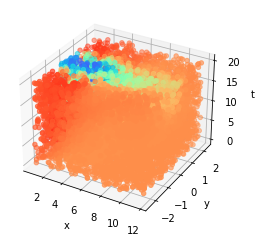

In [5]:
ax = plt.axes(projection ='3d')
ax.scatter3D(x_train, y_train,t_train,c=u_train,cmap='rainbow')
ax.set_title('')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t')
plt.show()

In [6]:
x = sn.Variable("x", dtype='float64')
y = sn.Variable("y", dtype='float64')
t = sn.Variable("t", dtype='float64')

In [7]:
P = sn.Functional("P", [x, y, t], [20, 20, 20, 20, 20, 20, 20, 20, 20], 'tanh')
Psi = sn.Functional("Psi", [x, y, t], [20, 20, 20, 20, 20, 20, 20, 20, 20], 'tanh')

In [8]:
lambda1 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda1")
lambda2 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda2")

In [9]:
u = sn.diff(Psi, y)
v = -sn.diff(Psi, x)

u_t = sn.diff(u, t)
u_x = sn.diff(u, x)
u_y = sn.diff(u, y)
u_xx = sn.diff(u, x, order=2)
u_yy = sn.diff(u, y, order=2)

v_t = sn.diff(v, t)
v_x = sn.diff(v, x)
v_y = sn.diff(v, y)
v_xx = sn.diff(v, x, order=2)
v_yy = sn.diff(v, y, order=2)

p_x = sn.diff(P, x)
p_y = sn.diff(P, y)

In [10]:
# Define constraints 
d1 = sn.Data(u,name='data')
d2 = sn.Data(v,name='data')
d3 = sn.Data(P,name='data')

c1 = sn.Tie(-p_x, u_t+lambda1*(u*u_x+v*u_y)-lambda2*(u_xx+u_yy))
c2 = sn.Tie(-p_y, v_t+lambda1*(u*v_x+v*v_y)-lambda2*(v_xx+v_yy))
c3 = sn.Data(u_x + v_y)


In [11]:
c4 = Psi*0.0


In [12]:
model = sn.SciModel(
    inputs=[x, y, t],
    targets=[d1, d2, d3, c1, c2, c3, c4],
    loss_func="mse"
)

In [13]:
input_data = [x_train, y_train, t_train]


In [14]:
data_d1 = u_train
data_d2 = v_train
data_d3 = p_train
data_c1 = 'zeros'
data_c2 = 'zeros'
data_c3 = 'zeros'
data_c4 = 'zeros'
target_data = [data_d1, data_d2, data_d3, data_c1, data_c2, data_c3, data_c4]

In [15]:
history = model.train(
    x_true=input_data,
    y_true=target_data,
    epochs=100,
    batch_size=50,
    shuffle=True,
    learning_rate=0.001,
    reduce_lr_after=100,
    stop_loss_value=1e-8,
    verbose=1
)



Total samples: 9000 
Batch size: 50 
Total batches: 180 

Epoch 1/100
180/180 [==============================] - 126s 328ms/step - batch: 89.5000 - size: 50.0000 - loss: 0.4811 - Grad__loss: 0.3436 - mul_loss: 0.0179 - P_loss: 0.0515 - sub_2_loss: 0.0596 - sub_4_loss: 0.0085 - add_7_loss: 7.1432e-34 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 126.2490
Epoch 2/100
180/180 [==============================] - 61s 336ms/step - batch: 89.5000 - size: 50.0000 - loss: 0.1713 - Grad__loss: 0.0984 - mul_loss: 0.0085 - P_loss: 0.0290 - sub_2_loss: 0.0300 - sub_4_loss: 0.0054 - add_7_loss: 8.5345e-34 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 60.5101
Epoch 3/100
180/180 [==============================] - 59s 326ms/step - batch: 89.5000 - size: 50.0000 - loss: 0.1041 - Grad__loss: 0.0552 - mul_loss: 0.0045 - P_loss: 0.0254 - sub_2_loss: 0.0157 - sub_4_loss: 0.0033 - add_7_loss: 8.3637e-34 - mul_12_loss: 0.0000e+00 - lr: 0.0010 - time: 58.6340
Epoch 4/100
180/180 [===========================

In [52]:
print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))


lambda1: [1.04485208],  lambda2: [0.02003305]


In [16]:
print("lambda1: {},  lambda2: {}".format(lambda1.value, lambda2.value))


lambda1: [1.49804222],  lambda2: [0.0280817]


Text(0, 0.5, 'loss')

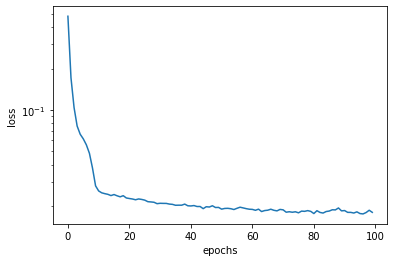

In [17]:
plt.semilogy(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [18]:
x_test,y_test,t_test,u_test,v_test,p_test=prepdata(100000,random=False)

In [19]:
p_pred=P.eval(model,[x_test,y_test,t_test])

In [20]:
ax=x_test
ay=y_test

ax=np.unique(ax)
xmin=min(ax)
dx=ax[3]-ax[2]
xmax=max(ax)
#print(np.unique(ax).shape[0])
if(dx==0):
    print("check!")
ay=np.unique(ay)

ymin=min(ay)
dy=ay[2]-ay[1]
ymax=max(ay)+dy

x,y=np.meshgrid(np.arange(xmin,xmax,dx),np.arange(ymin,ymax,dy))


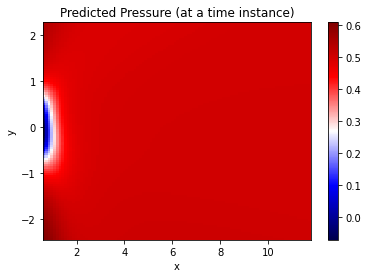

In [29]:
p_pred=np.reshape(p_pred,(10000,200))
p_plot=p_pred[:,10]
#print(p_plot.shape)
p_plot=np.reshape(p_plot,(100,100))
plt.pcolor(x,y,p_plot,cmap='seismic')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted Pressure (at a time instance)')
plt.colorbar()


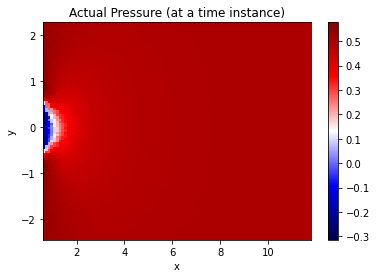

In [30]:
p_tr=np.reshape(p_test,(10000,200))
p_plot=p_tr[:,10]
p_plot=np.reshape(p_plot,(100,100))
plt.pcolor(x,y,p_plot,cmap='seismic')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Actual Pressure (at a time instance)')
plt.colorbar()

In [ ]:
p_pred=np.reshape(u_pred,(10000,200))
p_plot=p_pred[:,10]
#print(p_plot.shape)
p_plot=np.reshape(p_plot,(100,100))
plt.pcolor(x,y,p_plot,cmap='seismic')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted Pressure (at a time instance)')
plt.colorbar()
